#### Credits:
* https://www.youtube.com/watch?v=aSx0jg9ZILo&list=RDCMUCv83tO5cePwHMt1952IVVHw&start_radio=1&t=58s&ab_channel=JamesBriggs
* https://www.youtube.com/watch?v=WS1uVMGhlWQ&list=RDCMUCv83tO5cePwHMt1952IVVHw&start_radio=1&t=7s&ab_channel=JamesBriggs
* https://www.sbert.net/docs/package_reference/losses.html#
* https://www.sbert.net/docs/training/overview.html#training-overview
* https://huggingface.co/blog/how-to-train-sentence-transformers
* https://colab.research.google.com/github/huggingface/blog/blob/main/notebooks/95_Training_Sentence_Transformers.ipynb#scrollTo=yQ9v7x2J1C75


In [1]:
# Sentence Transformer Training
from sentence_transformers import SentenceTransformer, models, util
from transformers import BertTokenizer, BertForMaskedLM, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import datasets

c:\Users\manpresingh\Anaconda3\envs\python_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First let's understand how does a BERT model work and how can we extract embedding of each token and cls token from bert + what is a poolerlayer in a BERT model

In [32]:

mymodel = AutoModel.from_pretrained('bert-base-uncased')

In [33]:
mytokenizer   = BertTokenizer.from_pretrained('bert-base-uncased')

In [34]:
mymodel

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [35]:
myinp = mytokenizer("Hi my name is sahil", return_tensors='pt').input_ids.detach().clone()

In [36]:
myinp
# 101 is clsd token
# 102 is sep token

tensor([[  101,  7632,  2026,  2171,  2003,  7842, 19466,   102]])

In [37]:
model_output = mymodel(myinp)

In [38]:
model_output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1449,  0.4059, -0.0297,  ..., -0.3205,  0.2674,  0.4512],
         [ 0.7473,  0.3450,  0.1642,  ..., -0.1830,  0.8665, -0.2983],
         [-0.1289, -0.2079, -0.5767,  ...,  0.0032, -0.1666,  0.0268],
         ...,
         [-0.4583, -0.9067, -0.6471,  ..., -0.3482, -0.0265, -0.3044],
         [-0.2460, -0.7849, -0.2919,  ...,  0.0462,  0.0052, -0.5961],
         [ 0.6510, -0.0724, -0.3460,  ...,  0.0991, -0.4706, -0.3218]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8719, -0.5652, -0.8615,  0.7750,  0.7133, -0.1609,  0.8925,  0.4065,
         -0.6725, -1.0000, -0.2619,  0.9019,  0.9810,  0.5628,  0.9370, -0.7398,
         -0.2911, -0.6736,  0.4238, -0.3275,  0.7548,  1.0000,  0.2204,  0.3903,
          0.5318,  0.9807, -0.7826,  0.9304,  0.9602,  0.6603, -0.6938,  0.2801,
         -0.9885, -0.2830, -0.9092, -0.9899,  0.4661, -0.7705, -0.2522, -0.0087,
         -0.9077,  0.3934,  0.99

In [39]:
model_output.last_hidden_state.shape
# this gives embedding of each token in each batch

# [1          ,       8         ,            768]
# [Batch_Size , Sequence_Length , Embedding_size]

# batch_size: This dimension represents the number of input sequences in a batch.
# sequence_length: This dimension represents the number of tokens in each input sequence. Each token in the input sequence corresponds to a hidden state.
# hidden_size: This dimension represents the size of the hidden state vector for each token. The hidden state vector is a dense vector that the model learns to represent the token.

torch.Size([1, 8, 768])

In [40]:
# How do I get embedding of cls token ?
model_output.last_hidden_state[0][0].shape 
# since cls is the first token

torch.Size([768])

In [43]:
model_output.last_hidden_state[0][0]

tensor([-1.4489e-01,  4.0593e-01, -2.9678e-02, -4.4124e-01, -3.8764e-01,
        -5.5132e-01,  4.5563e-01,  7.0319e-01,  1.2862e-01, -1.1000e-01,
         3.0995e-01, -3.5125e-01,  1.8458e-01,  5.6166e-01,  9.9013e-02,
        -1.1360e-01, -1.8682e-01,  6.7795e-01,  4.1044e-01,  3.8926e-01,
         1.3039e-01, -3.5325e-01,  2.9176e-01,  1.2000e-01, -1.0376e-01,
        -4.9659e-02, -2.0558e-02,  1.6226e-01, -3.6677e-02, -3.4878e-01,
        -8.8985e-02,  3.2833e-01, -4.5909e-01, -1.8620e-02,  7.0480e-02,
         4.0118e-02,  1.6129e-01,  3.5809e-01,  1.2610e-01,  1.4492e-01,
        -1.7271e-01, -1.9686e-01,  1.7498e-01, -2.8174e-02, -5.6960e-02,
        -6.7475e-01, -2.7700e+00, -1.8288e-01, -2.1696e-01, -3.9872e-01,
         5.1370e-01, -2.1238e-01,  4.7443e-02,  2.8575e-01,  2.7958e-01,
         6.5901e-01, -6.6501e-01,  1.0913e-01, -9.0361e-02,  2.2439e-01,
         4.6945e-01, -2.4000e-02,  1.7758e-01,  1.7123e-01,  1.7159e-03,
         2.5638e-01, -3.5551e-02,  1.0677e-01, -1.0

In [49]:
model_output.pooler_output.shape, model_output.pooler_output[0]
# This pooler output is obtained by passing embedding of cls token from a nn.linear layer

(torch.Size([1, 768]),
 tensor([-0.8719, -0.5652, -0.8615,  0.7750,  0.7133, -0.1609,  0.8925,  0.4065,
         -0.6725, -1.0000, -0.2619,  0.9019,  0.9810,  0.5628,  0.9370, -0.7398,
         -0.2911, -0.6736,  0.4238, -0.3275,  0.7548,  1.0000,  0.2204,  0.3903,
          0.5318,  0.9807, -0.7826,  0.9304,  0.9602,  0.6603, -0.6938,  0.2801,
         -0.9885, -0.2830, -0.9092, -0.9899,  0.4661, -0.7705, -0.2522, -0.0087,
         -0.9077,  0.3934,  0.9999, -0.5236,  0.4267, -0.4493, -1.0000,  0.3089,
         -0.8814,  0.8270,  0.7991,  0.7141,  0.2960,  0.4814,  0.5064, -0.0323,
         -0.0092,  0.2306, -0.3751, -0.6366, -0.7093,  0.5409, -0.8390, -0.9176,
          0.7654,  0.7332, -0.2838, -0.3637, -0.1782, -0.0602,  0.9074,  0.3390,
         -0.0356, -0.8908,  0.4868,  0.3758, -0.6508,  1.0000, -0.5494, -0.9750,
          0.8776,  0.7527,  0.5633, -0.1213,  0.4707, -1.0000,  0.4399, -0.1375,
         -0.9888,  0.3816,  0.6756, -0.3407,  0.6906,  0.6120, -0.6827, -0.5600,
     

In [34]:
# Example:
cls_token_embedding = model_output.last_hidden_state[0][0]
print(cls_token_embedding.shape)
nn.Linear(768,768)(cls_token_embedding).shape

torch.Size([768])


torch.Size([768])

### now, let's see how sentenceTransformer works and how can we tune it

In [3]:
word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=512)

config.json: 100%|██████████| 570/570 [00:00<?, ?B/s] 
c:\Users\manpresingh\Anaconda3\envs\python_38\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manpresingh\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
model.safetensors: 100%|██████████| 440M/

In [52]:
word_embedding_model.get_word_embedding_dimension()

768

In [25]:
pooling_model =models.Pooling(word_embedding_model.get_word_embedding_dimension())

In [26]:
pooling_model

Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})

In [27]:
sent_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [30]:
sent_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [31]:
sent_model.encode("Hi my name is sahil")

array([ 9.61488485e-03, -6.61931261e-02, -1.89361691e-01, -5.11598885e-01,
        1.04098961e-01, -4.46902603e-01,  3.32490116e-01,  7.26778388e-01,
        3.10841858e-01, -2.87053674e-01,  3.38874340e-01, -5.14697909e-01,
        1.06199421e-02,  5.97718358e-01, -5.03250957e-01, -2.92162061e-01,
        1.13390833e-01,  3.50902617e-01,  3.05352509e-01,  8.56788695e-01,
        2.31122732e-01, -1.23133473e-01, -4.23504934e-02,  4.85026479e-01,
        2.94666201e-01,  1.62548780e-01, -9.50310379e-02,  4.34137017e-01,
       -1.07654393e-01, -2.88405001e-01, -2.71100014e-01, -1.77140087e-01,
       -4.40450102e-01,  4.97606583e-02, -1.66802198e-01, -3.16815376e-01,
       -3.69985461e-01,  1.77788138e-01, -5.00572979e-01,  1.96039468e-01,
       -7.13922203e-01, -6.26790047e-01,  1.88132077e-01, -1.46973997e-01,
        1.22761503e-02, -9.75218952e-01, -4.09094840e-02,  4.20127064e-02,
        4.26313207e-02, -4.20242548e-04,  2.82836080e-01, -3.10571373e-01,
       -4.11856622e-01,  

In [50]:
util.cos_sim(sent_model.encode("Hi my name is sahil"), model_output.pooler_output[0])

tensor([[0.0374]], grad_fn=<MmBackward0>)

### Now, let's see how can we train and Sentence Transformer model (Siamese Network Style)
**Here, the training is using original sttyle i.e. using 3 labels and softmax function**


#### Method1: From Scratch using PyTorch

#### Method2: Using SentenceTransformer wrapper

In [54]:
from datasets import load_dataset

In [55]:
dataset_id = "embedding-data/QQP_triplets"
# dataset_id = "embedding-data/sentence-compression"

dataset = load_dataset(dataset_id)

Generating train split: 101762 examples [00:00, 290518.89 examples/s]


In [56]:
print(f"- The {dataset_id} dataset has {dataset['train'].num_rows} examples.")
print(f"- Each example is a {type(dataset['train'][0])} with a {type(dataset['train'][0]['set'])} as value.")
print(f"- Examples look like this: {dataset['train'][0]}")

- The embedding-data/QQP_triplets dataset has 101762 examples.
- Each example is a <class 'dict'> with a <class 'dict'> as value.
- Examples look like this: {'set': {'query': 'Why in India do we not have one on one political debate as in USA?', 'pos': ['Why cant we have a public debate between politicians in India like the one in US?'], 'neg': ['Can people on Quora stop India Pakistan debate? We are sick and tired seeing this everyday in bulk?', 'Why do politicians, instead of having a decent debate on issues going in and around the world, end up fighting always?', 'Can educated politicians make a difference in India?', 'What are some unusual aspects about politics and government in India?', 'What is debate?', 'Why does civic public communication and discourse seem so hollow in modern India?', 'What is a Parliamentary debate?', "Why do we always have two candidates at the U.S. presidential debate. yet the ballot has about 7 candidates? Isn't that a misrepresentation of democracy?", 'Wh

In [68]:
dataset['train'][1]['set'].keys()
# Each input data has:
# # Query
# # positive sentence i.e similar sentence to Query
# # negative sentence i.e. collection of dis-similar sentences to Query

dict_keys(['query', 'pos', 'neg'])

In [69]:
dataset['train'][1]['set']

{'query': 'What is OnePlus One?',
 'pos': ['How is oneplus one?'],
 'neg': ['Why is OnePlus One so good?',
  'What would OnePlus 4 be like?',
  'What does the logo of oneplus phones mean?',
  'Should I root my OnePlus One?',
  'Do you like the OnePlus 2? Would you buy it?',
  'Which one do you prefer: the OnePlus Two or Moto G 2015?',
  'What is 1Google?',
  'Which root is stable for OnePlus Two?',
  'Oneplus 3 review from Indian user?',
  'How do you define "the one"?',
  'Is the OnePlus Two worth the purchase?',
  'What is an organism called when it is made of only one cell?',
  'I am confused between Vivo V5 and Oneplus 2 which one is better?',
  'Which is better Redmi Note 3 or OnePlus X?',
  'What is the difference between the OnePlus One 16gb and 64gb phones?',
  'How can I exchange my OnePlus 3 (15days old) for OnePlus 3t?',
  'I am planning to buy a OnePlus phone.Has the oneplus after sales service improved in India?',
  'What is one plus two?',
  'What is a haploid?',
  'How d

#### Different loss functions used in Sentencetransformer training and fine-tuning:
* TripletLoss
* SoftmaxLoss
* MultipleNegativesRankingLoss
* CachedMultipleNegativesRankingLoss
* MegaBatchMarginLoss
* CoSENTLoss
* ContrastiveLoss



### How to train a cross encoder / SentenceTransformer when you don't have any labelled data ?
* **Here the training is using MNR loss function**
* **What is MultipleNegativesRankingLoss**
    *    it is a useful loss function when we only have positive sentences

* *Credits theory: https://www.pinecone.io/learn/series/nlp/fine-tune-sentence-transformers-mnr/*
* *Credits Video: https://www.pinecone.io/learn/series/nlp/fine-tune-sentence-transformers-mnr/* 

#### Method  1: From Scratch using PyTorch

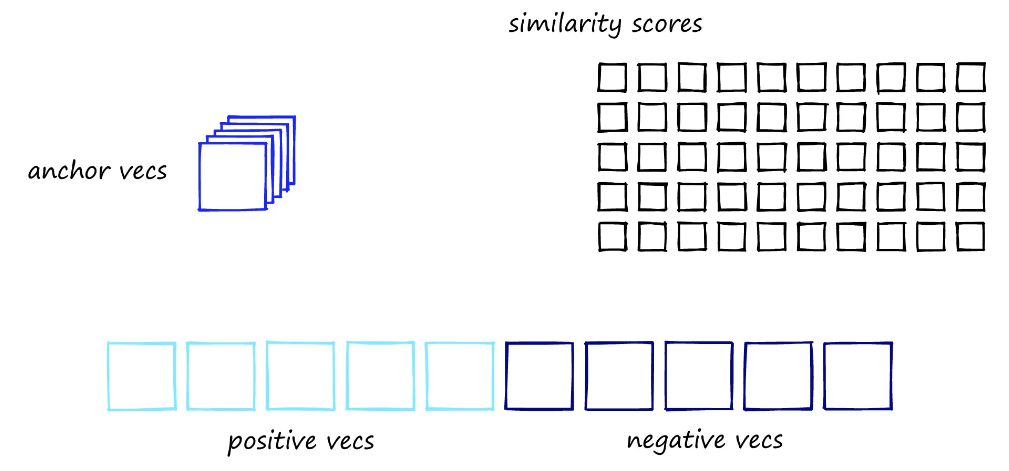

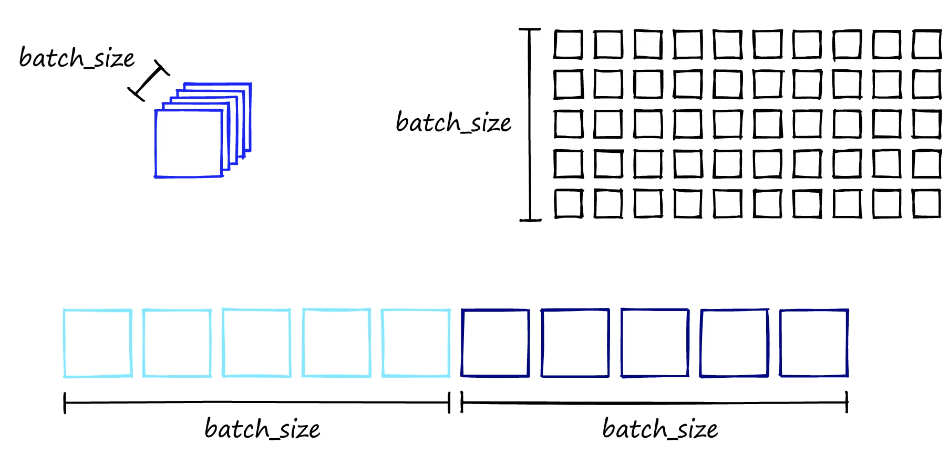

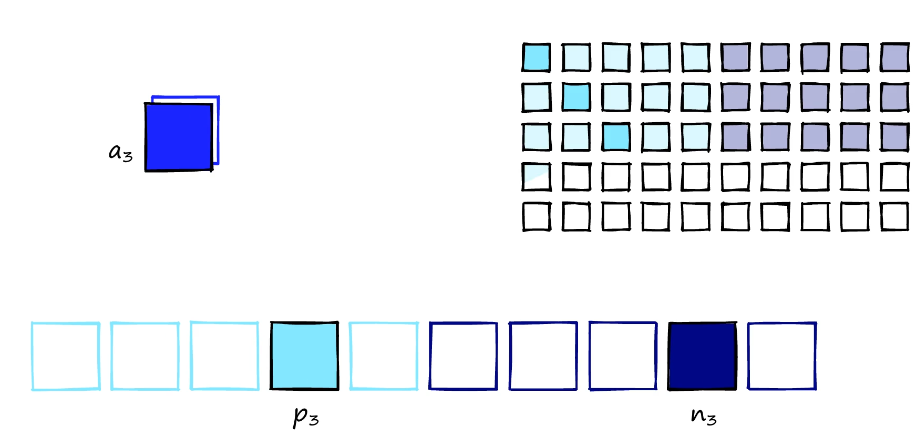

#### Method 2: Using SentenceTransformer Package

In [2]:
snli = datasets.load_dataset('snli', split='train')

In [3]:
snli

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
})

In [4]:
snli[0]
# Positive

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

In [5]:
snli[1]
# Contradicting

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is at a diner, ordering an omelette.',
 'label': 2}

In [6]:
snli[2]
# Entailment

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is outdoors, on a horse.',
 'label': 0}

In [7]:
mnli = datasets.load_dataset('glue','mnli', split='train')

In [8]:
mnli

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 392702
})

In [9]:
mnli = mnli.remove_columns(['idx'])
mnli

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 392702
})

In [10]:
snli = snli.cast(mnli.features)

In [11]:
dataset = datasets.concatenate_datasets([snli,mnli])

In [12]:
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 942854
})

In [13]:
# -1 label is when they couldn't decide the nature of the data (0, 1, or 2). So, we remove these datapoints
dataset = dataset.filter(
    lambda x: False if x['label']== -1 else True
)
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 942069
})

In [14]:
# Data with label 0, i.e., "Anchor + Positive" pair data only
dataset.filter(
    lambda x: True if x['label']==0 else False
)

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 314315
})

### Siamese Network
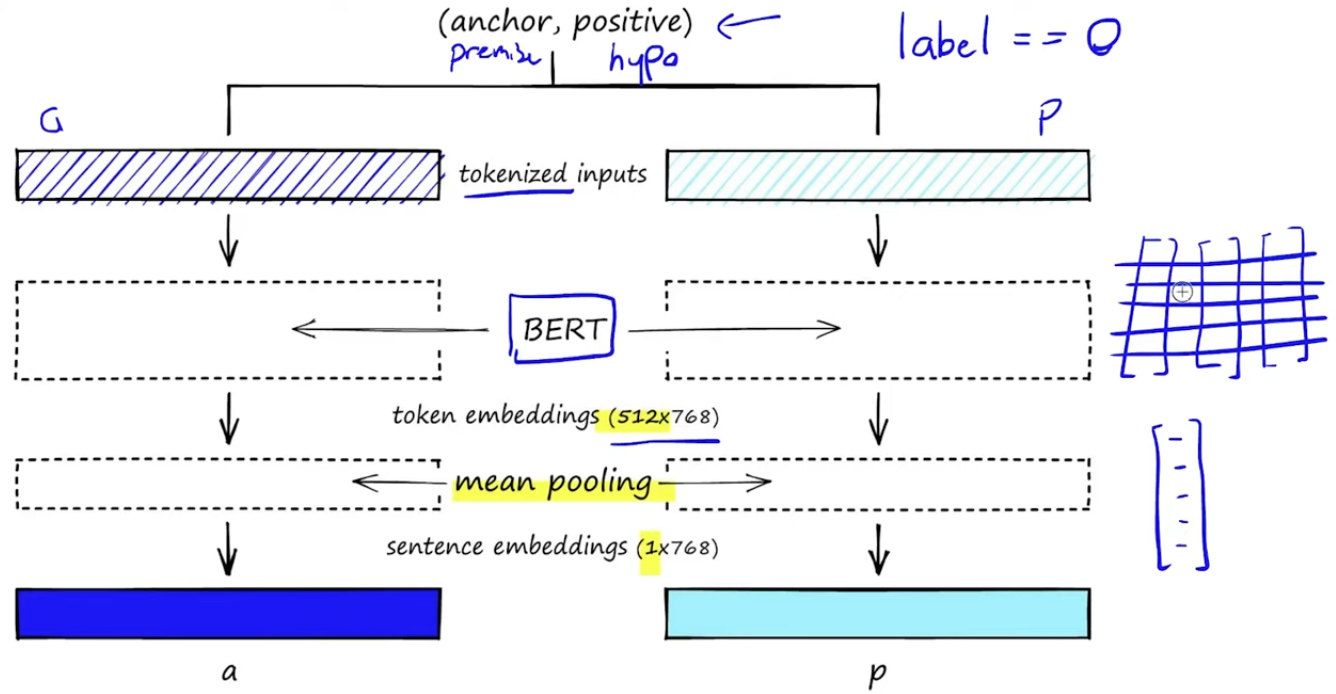

### Siamese network for Triplet
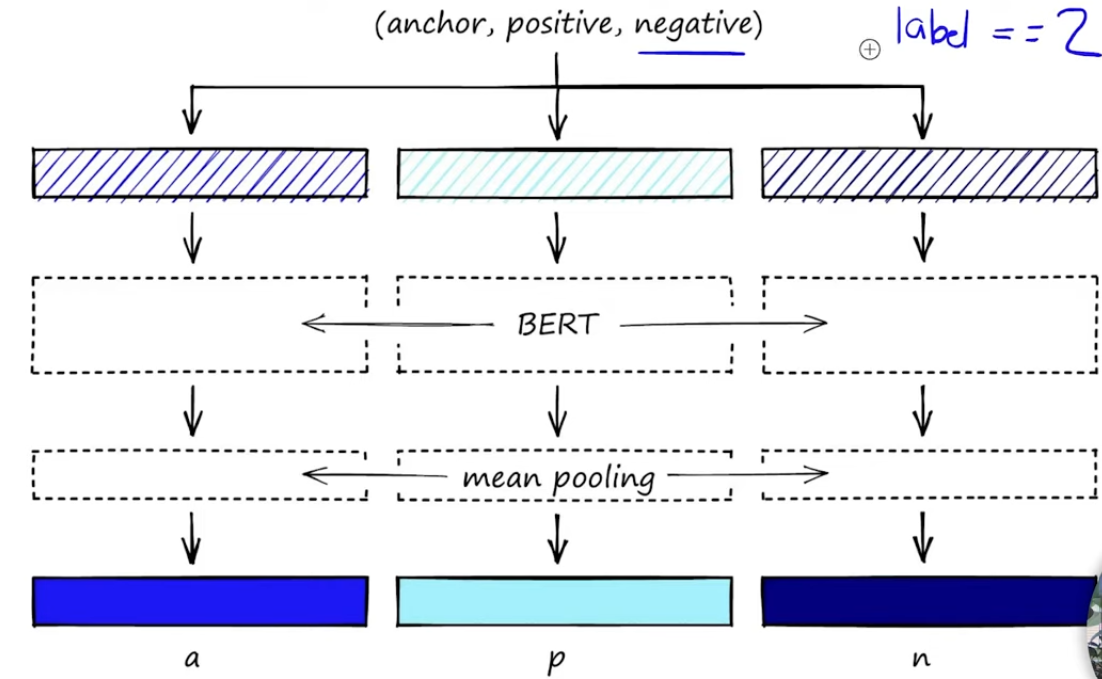

In [15]:
print(f"Before: {len(dataset)} rows")
dataset = dataset.filter(
    lambda x: False if x['label']!=0 else True 
)

print(f"After: {len(dataset)} rows")

Before: 942069 rows
After: 314315 rows


In [16]:
# InputExample
# this is the dataformat which is fed into Sentence transformer which the train methods of 
# sentencetransformer library would expect

In [17]:
from sentence_transformers import InputExample
from tqdm.auto import tqdm

In [18]:
samples = []
for row in tqdm(dataset):
    samples.append(InputExample(
        texts=[row['premise'], row['hypothesis']]
    ))

100%|██████████| 314315/314315 [00:23<00:00, 13179.90it/s]


In [19]:
from sentence_transformers import datasets

In [20]:
batch_size = 8

In [21]:
# NoDuplicatesDataLoader checks that we don't have duplicate within the same batch
# So, it's better than PyTorch dataloader

loader = datasets.NoDuplicatesDataLoader(
    samples, batch_size = batch_size
)

In [22]:
from sentence_transformers import SentenceTransformer, models

##### Different pooling techniques
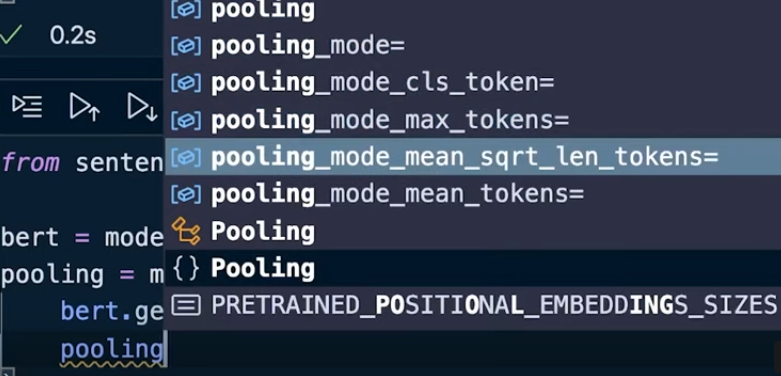

In [24]:
bert = models.Transformer('bert-base-uncased')

pooling_model = models.Pooling(
    bert.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True
)

mymodel = SentenceTransformer(modules=[bert, pooling_model])
mymodel

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [25]:
from sentence_transformers import losses

In [26]:
loss = losses.MultipleNegativesRankingLoss(mymodel)

In [27]:
loss

MultipleNegativesRankingLoss(
  (model): SentenceTransformer(
    (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
  (cross_entropy_loss): CrossEntropyLoss()
)

In [29]:
epochs = 1
warmup = int(.0001*len(loader))
warmup

3

In [30]:
device = torch.device('cude') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
mymodel.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [32]:
mymodel.fit(
    train_objectives = [(loader, loss)],
    epochs=epochs,
    warmup_steps = warmup,
    output_path='bert_mnr',
    show_progress_bar=False
)

In [35]:
mymodel

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [34]:
# How do we evaluate the model 

In [36]:
input_sentence=["I am going to play cricket today as it's sunday",
"I love playing cricket on Sunday",
"I am very kind to animals",
"I love dogs"]

In [37]:
embeddings = mymodel.encode(input_sentence)

In [54]:
embeddings.shape, embeddings

((4, 768),
 array([[ 0.04967614, -1.0239304 ,  0.5944123 , ...,  1.1401812 ,
          0.2541262 ,  0.19884598],
        [ 0.14785133, -0.71863663,  0.2635081 , ...,  0.9125774 ,
          0.1483418 ,  0.04411648],
        [ 0.40605548,  0.22948942, -0.33894497, ...,  0.24159274,
         -0.17023851,  0.52336204],
        [ 0.89204377,  0.7622852 , -0.32696804, ..., -0.68666375,
          0.29419026,  0.5629805 ]], dtype=float32))

In [41]:
import numpy as np
from sentence_transformers.util import cos_sim

def sim_matrix (model):
    sim = np.zeros((len(input_sentence), len(input_sentence)))
    for i in range(len(input_sentence)):
        sim[i:,i]= cos_sim(embeddings[i],embeddings[i:])
    return sim

In [49]:
# !pip install matplotlib
# !pip install seaborn

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

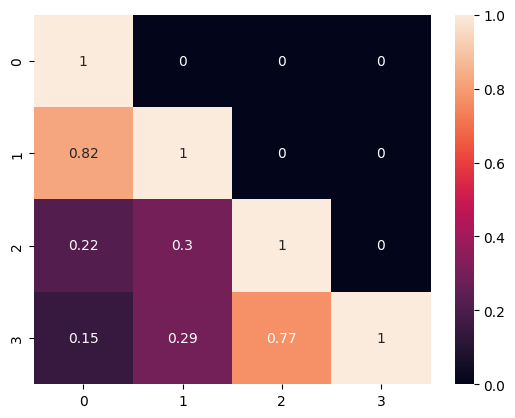

In [51]:
sim = sim_matrix(mymodel)
sns.heatmap(sim, annot=True)

In [52]:
# 1 and 2 similar
# 3 and 4 are similar